In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

In [2]:
datapath="/Users/xli77/Dropbox (GaTech)/MISA/results/SIVA/fixedSubspace/um2mm/seed7_snr1000"
subspace_struct_list=['234111','2222211','333111','441111','12x1']
num_subspace_struct=len(subspace_struct_list)

A = sio.loadmat("/Users/xli77/Dropbox (GaTech)/MISA/results/SIVA/fixedSubspace/mask/A_sz.mat")["A"]
A_msiva_s2 = A[1,1,:,:,:10]
id = sio.loadmat("/Users/xli77/Dropbox (GaTech)/MISA/MISA-data/sMRI-fMRI-DTI/SZID.mat")['ID'][0] - 1

data=sio.loadmat(os.path.join(datapath,f"subspace_struct_2222211","ummm_neuroimaging_sz_Y.mat"))
Y_msiva_s2=np.squeeze(data['Y2'])

Y_msiva_s2_shared_cca = sio.loadmat("/Users/xli77/Dropbox (GaTech)/MISA/results/SIVA/fixedSubspace/mask/Y_msiva_s2_cca_sz.mat")["Y_msiva_s2_cca"]
unique_source = np.concatenate( [np.expand_dims( Y_msiva_s2[0][-2:,:][:,id], axis=0 ), np.expand_dims( Y_msiva_s2[1][-2:,:][:,id], axis=0 )], axis=0 )
Y_msiva_s2_cca = np.concatenate( [Y_msiva_s2_shared_cca, unique_source], axis=1 )

data=sio.loadmat(os.path.join(datapath,f"subspace_struct_12x1","mm_neuroimaging_sz_Y.mat"))
Y_mmiva_s5=np.squeeze(data['Y3'])

In [3]:
r_sq = np.zeros((2, 5, 12))
r_sq_adj = np.zeros((2, 5, 12))

for m in range(2):
    for i, j in enumerate( np.arange(0,10,2) ):
        for k in range(12):
            msiva_s2 = Y_msiva_s2_cca[m,j:j+2,:].T
            mmiva_s5 = Y_mmiva_s5[m][k,id]
            results = sm.OLS(mmiva_s5, msiva_s2).fit()
            r_sq[m, i, k] = results.rsquared
            r_sq_adj[m, i, k] = results.rsquared_adj

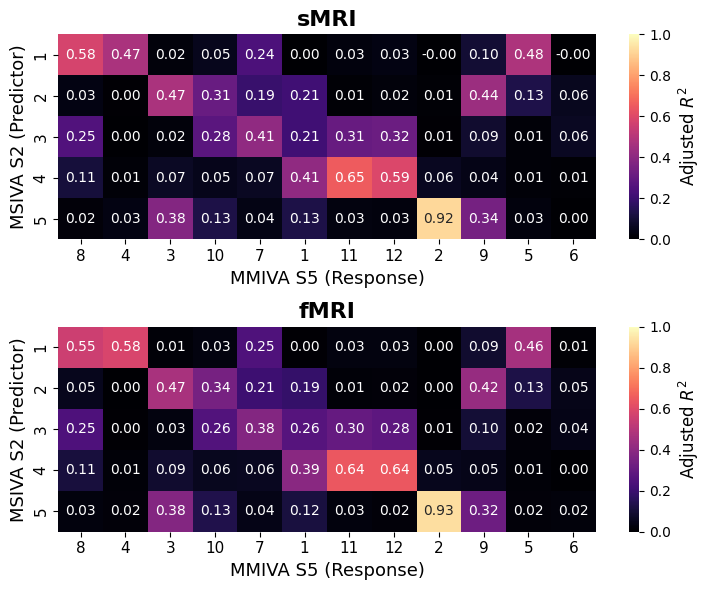

In [4]:
ind = [8,4,3,10,7,1,11,12,2,9,5,6]
ind0 = [ i - 1 for i in ind ]
title_list = ["sMRI", "fMRI"]

plt.figure(figsize=(7.5,6))

for i in range(2):
    plt.subplot(2,1,i+1)
    f = sns.heatmap(r_sq_adj[i][:,ind0], vmin=0, vmax=1, cmap="magma", annot=True, fmt=".2f")
    # sns.heatmap(r_sq[i], vmin=0, vmax=1, cmap="magma", annot=True, fmt=".2f")
    cb = f.collections[0].colorbar
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label=f"Adjusted $R^2$", fontsize=12)
    plt.title(f"{title_list[i]}", fontsize=16, fontweight="bold")
    plt.xlabel("MMIVA S5 (Response)", fontsize=13)
    plt.ylabel("MSIVA S2 (Predictor)", fontsize=13)
    plt.xticks(np.arange(0.5,12.5,1), np.arange(1,13)[ind0], fontsize=11)
    plt.yticks(np.arange(0.5,5.5,1), np.arange(1,6), fontsize=11)

plt.tight_layout()
plt.savefig("figures/Rsq_MMIVA_S5_vs_MSIVA_S2_reordered_CCA_SZ.pdf")

In [5]:
f_stats = np.zeros( (4, 2, 5, 6) )
p_vals = np.zeros( (4, 2, 5, 6) )

for m in range(2):
    for a, i in enumerate(np.arange(0,10,2)):
        for b, j in enumerate(np.arange(0,12,2)):
            y = Y_msiva_s2_cca[m,i:i+2,:].T
            X = Y_mmiva_s5[m][ind0][j:j+2,id].T

            data = np.concatenate((X, y), axis=1)
            data_name = ['S5SCV1', 'S5SCV2', 'S2SCV1', 'S2SCV2']
            df = pd.DataFrame(data, columns=data_name)
            df.head(5)

            # response ~ predictor
            model = MANOVA.from_formula('S2SCV1 + S2SCV2 ~ S5SCV1 + S5SCV2 + 0', data=df)
            
            f_val = model.mv_test([('all', np.eye(2))]).results['all']['stat']['Value']
            p_val = model.mv_test([('all', np.eye(2))]).results['all']['stat']['Pr > F']

            f_stats[0, m, a, b] = f_val.iloc[0] # Wilks' lambda
            f_stats[1, m, a, b] = f_val.iloc[1] # Pillai's trace
            f_stats[2, m, a, b] = f_val.iloc[2] # Hotelling-Lawley trace
            f_stats[3, m, a, b] = f_val.iloc[3] # Roy's greatest root

            p_vals[0, m, a, b] = p_val.iloc[0] # Wilks' lambda
            p_vals[1, m, a, b] = p_val.iloc[1] # Pillai's trace
            p_vals[2, m, a, b] = p_val.iloc[2] # Hotelling-Lawley trace
            p_vals[3, m, a, b] = p_val.iloc[3] # Roy's greatest root

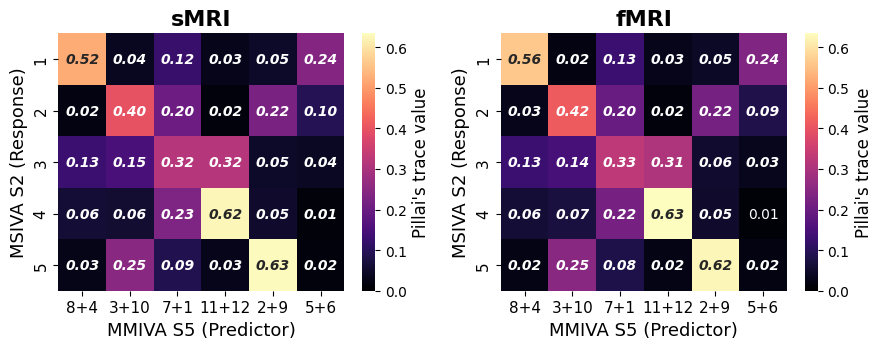

In [6]:
p_vals_logic = p_vals < 0.05/30
stats_list = ["Wilks' lambda", "Pillai's trace", "Hotelling-Lawley trace", "Roy's greatest root"]
modality_list = ["sMRI", "fMRI"]
xtick_list = ["8+4","3+10","7+1","11+12","2+9","5+6"]

for j in [1]:
    stats = stats_list[j]
    plt.figure(figsize=(9,3.6))
    for i in range(2):
        plt.subplot(1,2,i+1)
        f = sns.heatmap(f_stats[j, i]/2, mask=p_vals_logic[j, i]==True, vmin=0, vmax=np.max([np.max(f_stats[j,0]),np.max(f_stats[j,1])])/2, cmap="magma", annot=True, fmt=".2f")
        sns.heatmap(f_stats[j, i]/2, mask=p_vals_logic[j, i]==False, 
                    annot_kws={"style": "oblique", "weight": "bold"}, annot=True, fmt=".2f",
                    vmin=0, vmax=np.max([np.max(f_stats[j,0]),np.max(f_stats[j,1])])/2, cmap="magma", cbar=False)
        cb = f.collections[0].colorbar
        cb.ax.tick_params(labelsize=10)
        cb.set_label(label=f"{stats} value", fontsize=12)
        plt.title(f"{modality_list[i]}", fontsize=16, fontweight="bold")
        plt.xlabel("MMIVA S5 (Predictor)", fontsize=13)
        plt.ylabel("MSIVA S2 (Response)", fontsize=13)
        plt.xticks(np.arange(0.5,6.5,1), xtick_list, fontsize=11)
        plt.yticks(np.arange(0.5,5.5,1), np.arange(1,6), fontsize=11)
    stats.replace("'", "")
    stats.replace(" ", "_")
    plt.tight_layout()
    plt.savefig(f"figures/multivariate_regression_value_{stats}_bold_SZ.pdf")